
    This Source Code Form is subject to the terms of the Mozilla Public
    License, v. 2.0. If a copy of the MPL was not distributed with this
    file, You can obtain one at http://mozilla.org/MPL/2.0/.


In [1]:
import json
import matplotlib.pyplot as plt
import matplotlib.transforms
import numpy as np
import pandas as pd
import seaborn as sns
from statsmodels.stats import weightstats as stests

### Global parameter to build seaborn boxplot

In [2]:
path = 'data/IWLCS/'
offset_path = len(path)

# Comment or uncomment following paths to see results for each experience we conduct

# A ) ACS2 without GA and without Pees vs ACS2 without GA and with Pees 
file_name_lcs_1 = 'acs2_no_pees.json'
file_name_lcs_2 = 'acs2_pees.json'

# B ) ACS2 without GA and with Pees vs ACS2 with GA and with Pees 
#file_name_lcs_1 = 'acs2_pees.json'
#file_name_lcs_2 = 'acs2_pees_ga.json'

json_data_from_lcs_1 = path + file_name_lcs_1
json_data_from_lcs_2 = path + file_name_lcs_2

# Font size et figuresize parameters for plotting

figure_size = (20, 10)
axe_label_fontsize = '24'
tick_label_fontsize = '20'
legend_fontsize = '20'

# Significiance level
alpha = 0.01

### Reading json files

In [3]:
with open(json_data_from_lcs_1) as json_file_1:
    raw_data_from_lcs_1 = json.load(json_file_1)
    
with open(json_data_from_lcs_2) as json_file_2:
    raw_data_from_lcs_2 = json.load(json_file_2)

raw_data = [raw_data_from_lcs_1,raw_data_from_lcs_2]
lcs_name = [json_data_from_lcs_1[offset_path:-5], json_data_from_lcs_2[offset_path:-5]]

### Preparing pandas plotting data

In [4]:
cleaned_data = {
    'LCS':[], 
    'Maze':[], 
    'Knowledge (%)':[],
    'Population of macro classifiers':[], 
    'Reliable classifiers':[],
    'Ratio of Pees matching non aliased states':[], 
    'Mean realiable classifier specificity':[], 
    'Full Knowledge for first time (trial)':[], 
    'Stable Full Knowledge (trial)':[]
}

nb_of_environments = 0

for i in range(len(lcs_name)):
    for item in raw_data[i]:
        if 'time' not in item.keys():
            nb_of_environments += 1
            for idx in range(len(item['knowledge_list'])):
                cleaned_data['LCS'].append(lcs_name[i])
                cleaned_data['Maze'].append(item['maze'])
                cleaned_data['Knowledge (%)'].append(item['knowledge_list'][idx])
                cleaned_data['Population of macro classifiers'].append(item['population_list'][idx])
                cleaned_data['Reliable classifiers'].append(item['reliable_list'][idx])
                cleaned_data['Ratio of Pees matching non aliased states'].append(
                    float(item['pees_matching_non_aliased_states_list'][idx]) / item['population_list'][idx]
                )
                cleaned_data['Mean realiable classifier specificity'].append(item['mean_reliable_classifier_specificity_list'][idx])
                cleaned_data['Full Knowledge for first time (trial)'].append(item['full_knowledge_first_trial_list'][idx])
                cleaned_data['Stable Full Knowledge (trial)'].append(item['full_knowledge_stable_trial_list'][idx])

nb_of_environments /= len(lcs_name)
                
pandas_data = pd.DataFrame(cleaned_data)

### Preparing statistical data from raw read json

In [5]:
raw_list_by_env_name = {}
for i in range(len(lcs_name)):
    for item in raw_data[i]:
        if 'time' not in item.keys():
            if item['maze'] not in raw_list_by_env_name.keys():
                raw_list_by_env_name[item['maze']] = {
                    'knowledge_list' : [],
                    'population_list' : [],
                    'reliable_list' : [],
                    'pees_matching_non_aliased_states_list' : [],
                    'mean_reliable_classifier_specificity_list' : [],
                    'full_knowledge_first_trial_list' : [],
                    'full_knowledge_stable_trial_list' : []
                }
            raw_list_by_env_name[item['maze']]['knowledge_list'].append(
                np.array(item['knowledge_list']))
            raw_list_by_env_name[item['maze']]['population_list'].append(np.array(
                item['population_list']))
            raw_list_by_env_name[item['maze']]['reliable_list'].append(np.array(
                item['reliable_list']))
            raw_list_by_env_name[item['maze']]['pees_matching_non_aliased_states_list'].append(np.array(
                [float(a)/b for a,b in zip(item['pees_matching_non_aliased_states_list'], item['population_list'])]))
            raw_list_by_env_name[item['maze']]['mean_reliable_classifier_specificity_list'].append(
                np.array(item['mean_reliable_classifier_specificity_list']))
            raw_list_by_env_name[item['maze']]['full_knowledge_first_trial_list'].append(
                np.array(item['full_knowledge_first_trial_list']))
            raw_list_by_env_name[item['maze']]['full_knowledge_stable_trial_list'].append(
                np.array(item['full_knowledge_stable_trial_list']))
            

### Plotting boxplots with seaborn

In [6]:
rc={
    'axes.labelsize':axe_label_fontsize,
    'xtick.labelsize':tick_label_fontsize,
    'ytick.labelsize':tick_label_fontsize
}
sns.set(context='notebook', style='ticks', rc=rc)

In [7]:
def plot_figure(pandas_data, Y, legend_loc):
    
    # Build the main figure
    fig, ax = plt.subplots(figsize=figure_size)
    sns.stripplot(
        x = 'Maze',
        y = Y,
        hue = 'LCS',
        data = pandas_data,
        edgecolor='gray',
        jitter=True,
        linewidth = 1,
        dodge=True,
        palette='pastel',
        ax = ax
    )
    sns.boxplot(
        x = 'Maze',
        y = Y,
        hue = 'LCS',
        data = pandas_data,
        fliersize=0,
        palette='pastel',
        ax = ax
    )

    # Set up x tick labels and x label correctly
    plt.xticks(rotation = 45, horizontalalignment = 'right')
    plt.xlabel('')

    # Hide the horizontal gridlines
    ax.yaxis.grid(False)

    # Show the vertical gridlines
    ax.xaxis.grid(True)

    # Shift major ticks to create column for each maze
    plt.xticks(np.arange(nb_of_environments)+0.5)

    # Set up minor ticks and align label of major ticks on minor ticks
    ax.xaxis.set_minor_locator(plt.MultipleLocator(0.5))
    dx = (((figure_size[0] * 100 / 4.))/nb_of_environments - 10)/72.; dy = 0/72. # Width in inches converted into pixels depending on default DPI
    offset = matplotlib.transforms.ScaledTranslation(dx, dy, fig.dpi_scale_trans)
    for label in ax.xaxis.get_majorticklabels():
        label.set_transform(label.get_transform() - offset)

    # Set up legend
    handles, labels = ax.get_legend_handles_labels()
    plt.legend(handles[0:2], labels[0:2], frameon=False, loc=legend_loc, fontsize=legend_fontsize)

In [8]:
def plot_knowledge(pandas_data, zipped:bool=True):
        
    plot_figure(pandas_data, Y='Knowledge (%)', legend_loc='lower right')

In [9]:
def plot_population(pandas_data, only_reliable:bool=False):

    if not only_reliable:
        Y = 'Population of macro classifiers'
    else:
        Y = 'Reliable classifiers'

    plot_figure(pandas_data, Y=Y, legend_loc='upper right')

In [10]:
def plot_non_aliased_pees_ratio(pandas_data):
    
    plot_figure(pandas_data, Y='Ratio of Pees matching non aliased states', legend_loc='upper right')

In [11]:
def plot_mean_classifier_specificity(pandas_data):
    
    plot_figure(pandas_data, Y='Mean realiable classifier specificity', legend_loc='upper right')

In [12]:
def plot_first_time_full_knowledge_achieved(pandas_data):
    
    plot_figure(pandas_data, Y='Full Knowledge for first time (trial)', legend_loc='upper right')

In [13]:
def plot_stable_full_knowledge_achieved(pandas_data):
    
    plot_figure(pandas_data, Y='Stable Full Knowledge (trial)', legend_loc='upper right')

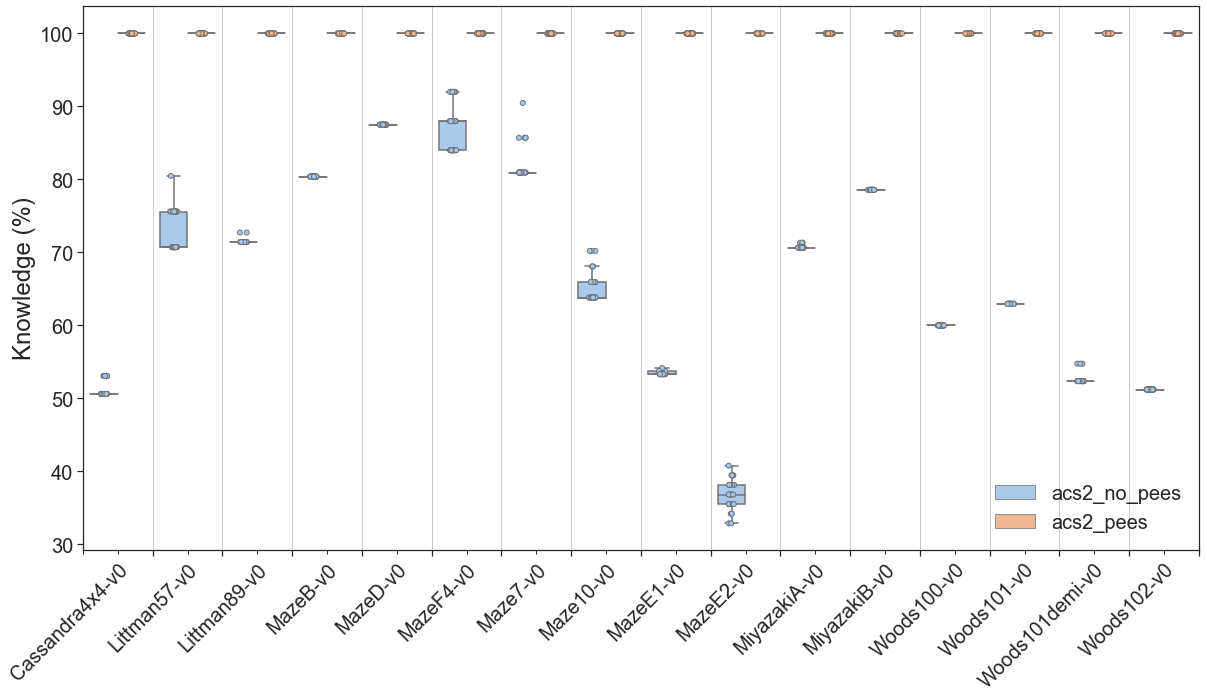

In [14]:
plot_knowledge(pandas_data)

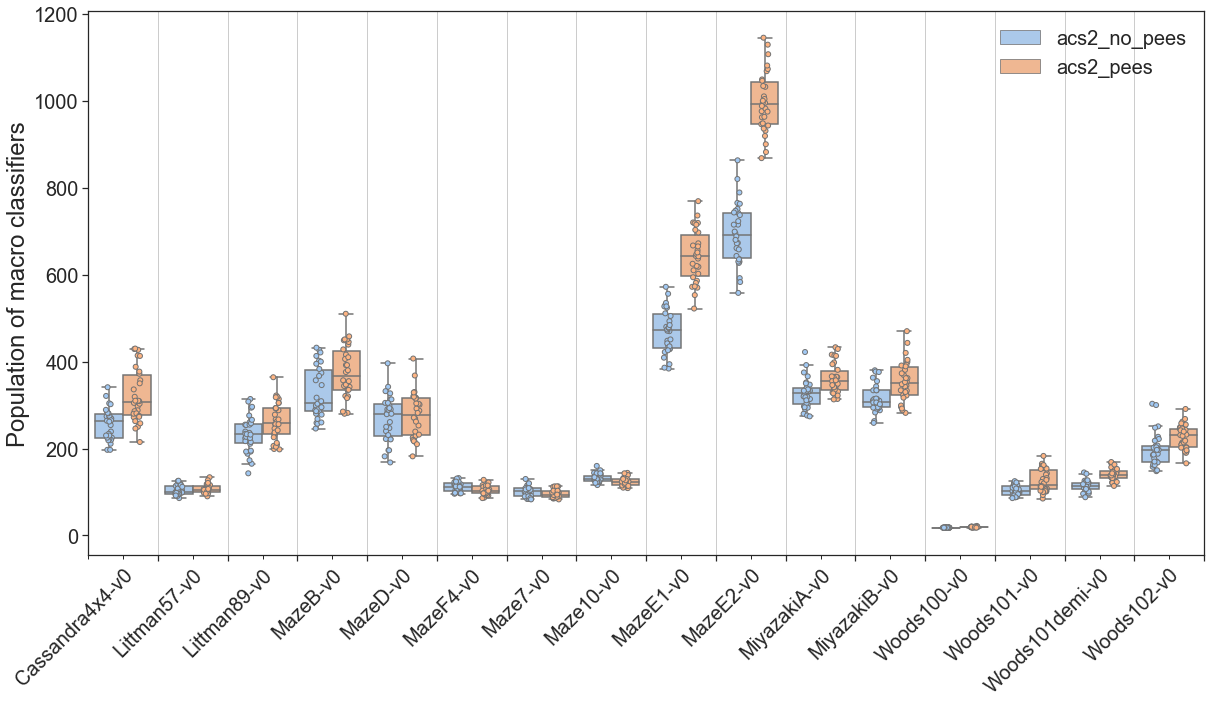

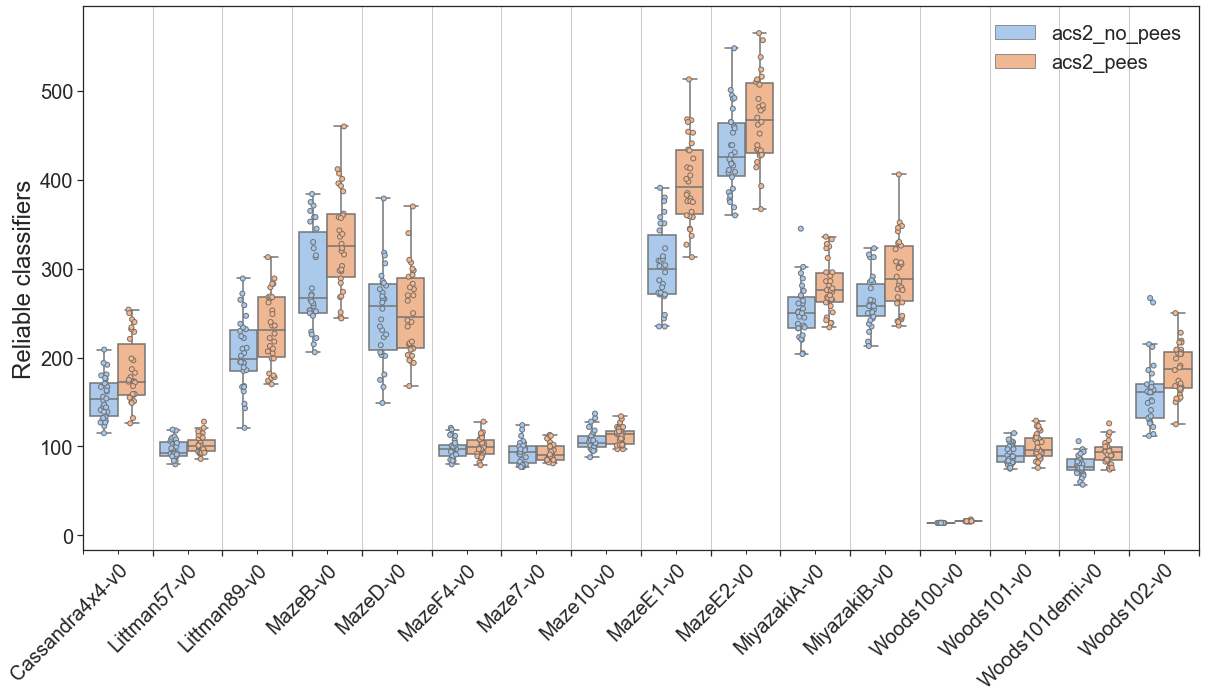

In [15]:
plot_population(pandas_data, only_reliable=False)
plot_population(pandas_data, only_reliable=True)

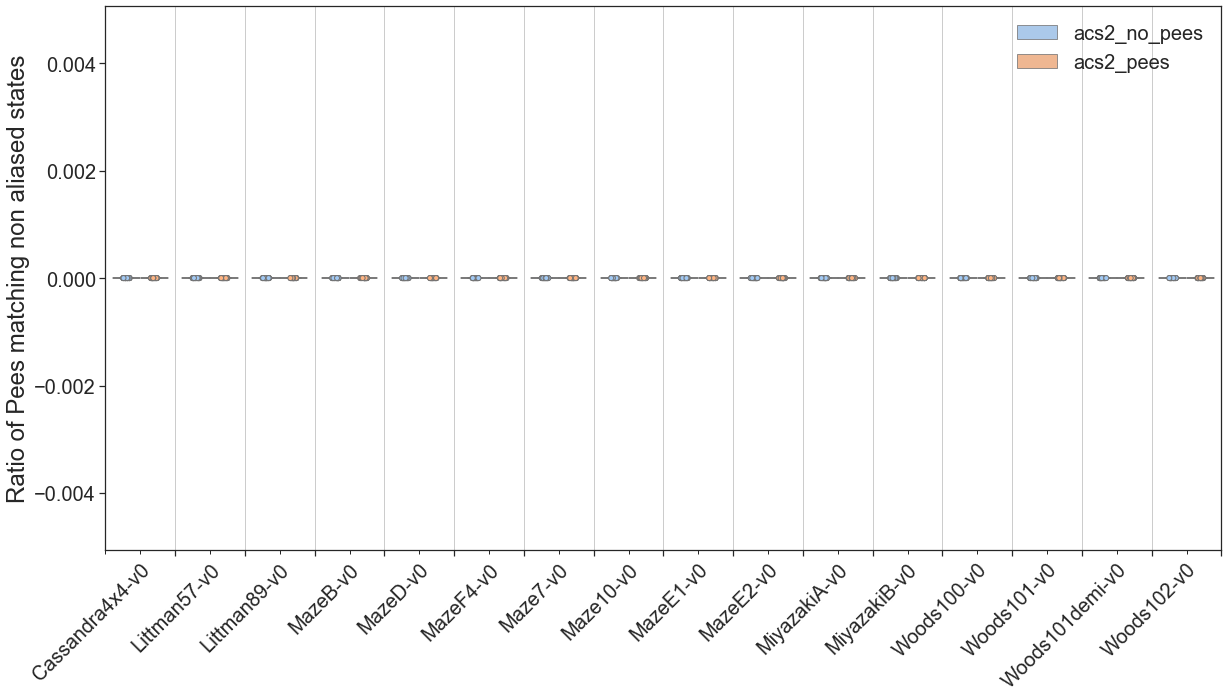

In [16]:
plot_non_aliased_pees_ratio(pandas_data)

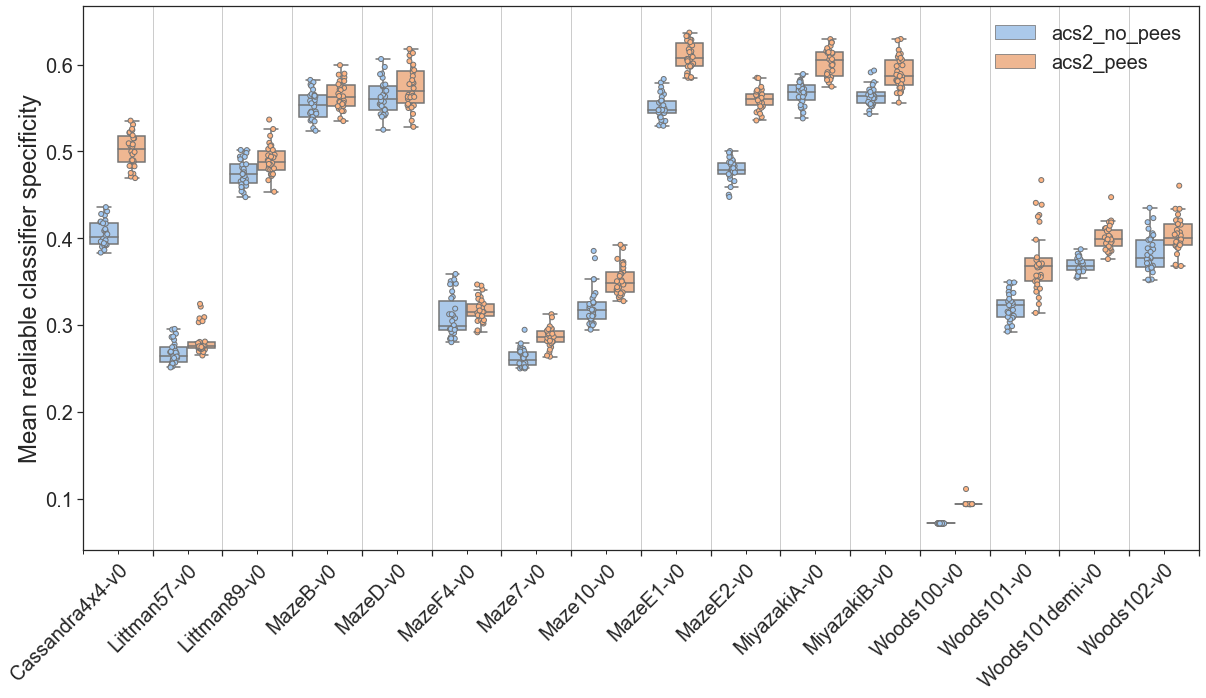

In [17]:
plot_mean_classifier_specificity(pandas_data)

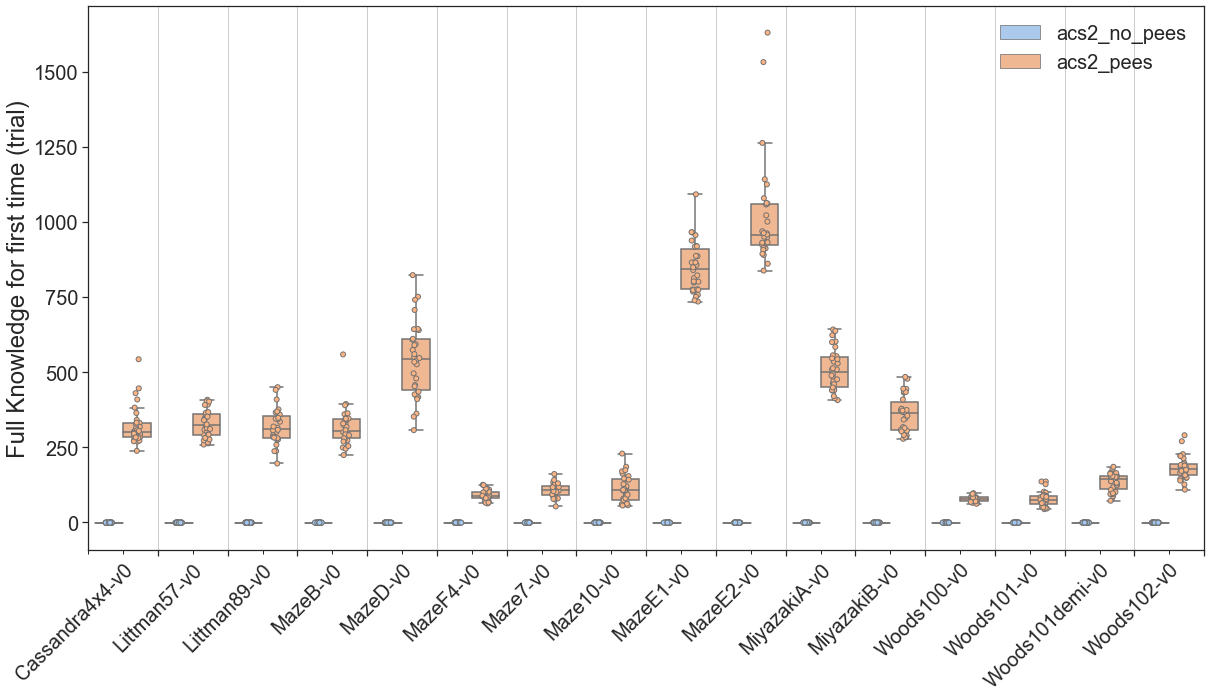

In [18]:
plot_first_time_full_knowledge_achieved(pandas_data)

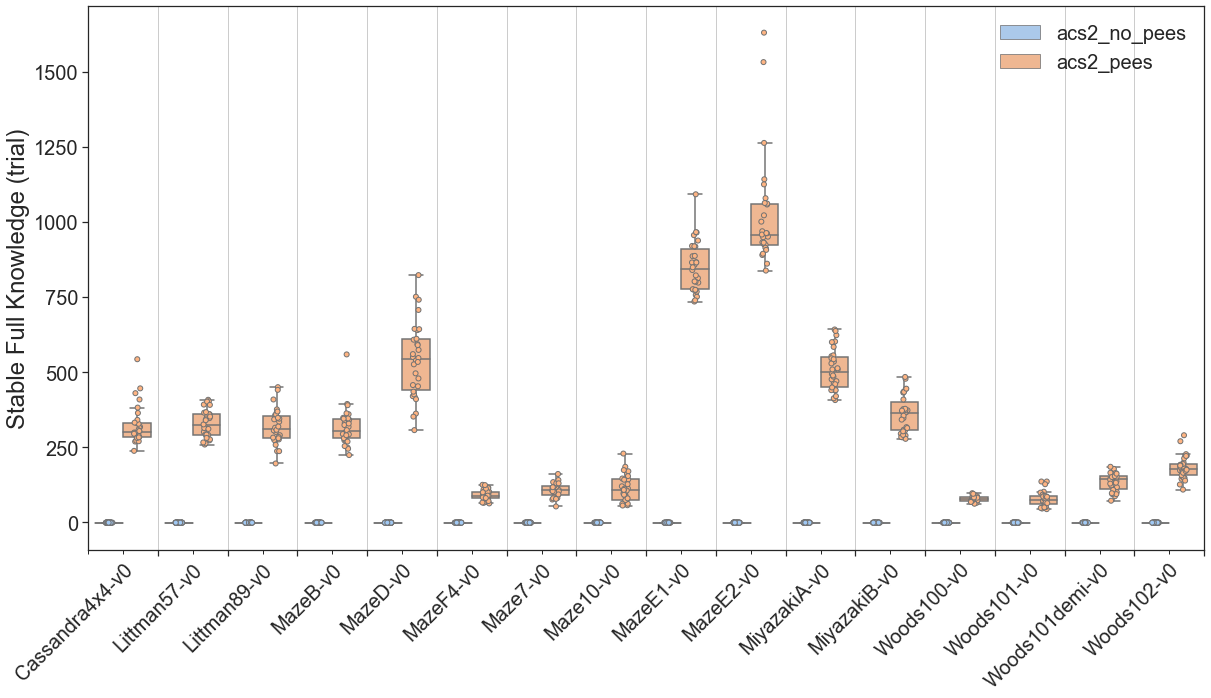

In [19]:
plot_stable_full_knowledge_achieved(pandas_data)

### Computing p-values

In [20]:
raw_statistical_data = {
    'Maze':[],
    'Metric':[],
    'Alternative':[],
    'P Value':[],
    'Null Hypothesis':[]
}
for env_name in raw_list_by_env_name.keys():
    for metric in raw_list_by_env_name[env_name].keys():
        for i in range(3):
            raw_statistical_data['Maze'].append(env_name)
            raw_statistical_data['Metric'].append(metric)
            array1 = stests.DescrStatsW(raw_list_by_env_name[env_name][metric][0])
            array2 = stests.DescrStatsW(raw_list_by_env_name[env_name][metric][1])
            if i == 0:
                raw_statistical_data['Alternative'].append('two-sided')
                tstats, pvalue = stests.CompareMeans(array1,array2).ztest_ind(
                    alternative='two-sided', usevar='unequal', value=0)
            elif i == 1:
                raw_statistical_data['Alternative'].append('larger')
                tstats, pvalue = stests.CompareMeans(array1,array2).ztest_ind(
                    alternative='larger', usevar='unequal', value=0)
            else:
                raw_statistical_data['Alternative'].append('smaller')
                tstats, pvalue = stests.CompareMeans(array1,array2).ztest_ind(
                    alternative='smaller', usevar='unequal', value=0)
            raw_statistical_data['P Value'].append(pvalue)
            if pvalue<alpha:
                raw_statistical_data['Null Hypothesis'].append('Reject')
            else:
                raw_statistical_data['Null Hypothesis'].append('Accept')
statistical_pandas = pd.DataFrame(raw_statistical_data)

/Users/romain/anaconda3/lib/python3.7/site-packages/statsmodels/stats/weightstats.py:655: RuntimeWarning: invalid value encountered in double_scalars
  zstat = (value1 - value2 - diff) / std_diff
/Users/romain/anaconda3/lib/python3.7/site-packages/statsmodels/stats/weightstats.py:655: RuntimeWarning: divide by zero encountered in double_scalars
  zstat = (value1 - value2 - diff) / std_diff


In [21]:
statistical_pandas.to_csv(path + lcs_name[0] + '_' + lcs_name[1] + '_stats.csv')